In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.linalg import norm

In [3]:
import librosa

In [17]:
#!mkdir ./utils
#!curl -o ./utils/simplex_projection.py https://gist.githubusercontent.com/daien/1272551/raw/df474b9c7600cc66d27b6df88d5266d7cb6d9e95/simplex_projection.py

Robust PCA:

Data matrix = Low-rank matrix + Sparse matrix

<img src="http://kojinoshiba.com/assets/images/2018-05-27-robust-pca/robust_pca.png" width=600>

https://statweb.stanford.edu/~candes/math301/Lectures/rpca.pdf

Альтернативная формулировка RPCA:

\begin{gather}
\min_{\mathbf{L}, \mathbf{E}}  \lVert \mathbf{X} - \mathbf{L} - \mathbf{E}\rVert_F^2 \\
s.t. \mathrm{rank}(\mathbf{L}) \leq k, \mathrm{card}(\mathbf{E}) \leq r
\end{gather}

После [релаксации](https://www.idi.ntnu.no/~schellew/convexrelaxation/ConvexRelaxation.html):

\begin{gather}
\min_{\mathbf{L}, \mathbf{E}}  \lVert \mathbf{X} - \mathbf{L} - \mathbf{E}\rVert_F^2 \\
s.t.  \lVert \mathrm{vec} (\mathbf{E}) \rVert_1 \leq \lambda,  \lVert \mathbf{L} \rVert_* \leq \gamma
\end{gather}

<imp src="https://tianyizhou.files.wordpress.com/2011/04/background.jpg">

<imp src="https://raw.githubusercontent.com/dfm/pcp/master/demo.png">

<imp src="https://ars.els-cdn.com/content/image/1-s2.0-S1047320314001989-gr1.jpg">


In [22]:
import sys
sys.path.append('./')

from utils.simplex_projection import euclidean_proj_simplex

def euclidean_proj_l1_ball(v, s=1):
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = euclidean_proj_simplex(u, s=s)
    w *= np.sign(v)
    return w

In [23]:
from scipy.sparse.linalg import svds

def nuclear_lmo(grad, gamma, shape=None):
    if not shape==None:
        u,s,vt = svds(grad.reshape(shape), k=1)
        return -gamma*np.outer(u,vt).flatten()
    else:
        u,s,vt = svds(grad, k=1)
        return -gamma*np.outer(u,vt)

In [24]:
def l1_lmo(grad, gamma):
    idx = np.argmax(np.abs(grad))
    x = np.zeros(grad.shape)
    x[idx] = -gamma*np.sign(grad[idx])
    return x

In [51]:
from scipy.optimize import line_search, minimize_scalar


def robustPCA(Y, lmbda, gamma, max_iter=500):
    """
    Robust PCA via Frank-Wolfe and projected gradient [http://www.columbia.edu/~jw2966/papers/MZWG14-pp.pdf]
    
    Parameters
    -------
    Y : ndarray, shape (M,N)
        Data matrix (of the size M x N) to be decomposed
    lmbda : float > 0
        Radius of the L1 norm ball
    gamma : float > 0
        Radius of the nuclear norm ball
    max_iter : int
        Maximum number of iterations  
    
    Returns
    -------
    L : ndarray, shape (M,N)
        Low-rank matrix
    S : ndarray, shape (M,N)
        Sparse matrix
    """
    
    M,N = Y.shape
    # initial solution
    L = Y.copy()
    S = np.random.randn(M,N)
    L = nuclear_lmo(L, gamma)
    S = l1_lmo(S.flatten(), lmbda).reshape(S.shape)    
    k = 0
    d = np.inf
    while d > 1e-4 and k < max_iter:
        # gradient
        grad = L + S - Y
        # LMO
        V_L = nuclear_lmo(grad, gamma)
        V_S = l1_lmo(grad.flatten(), lmbda).reshape(S.shape)
        d = np.sum(grad*(L - V_L)) + np.sum(grad*(S - V_S))
        #stepsize
        alpha = 2./(k+2.) #standard stepsize
        #alpha = minimize_scalar(lambda a: func(x + a*(s - x)), bounds=(0, 1)).x 
        # update solution
        L = L + alpha*(V_L - L)
        S = S + alpha*(V_S - S)
        # update S with projected gradient
        S = euclidean_proj_l1_ball((Y - L).flatten(), lmbda).reshape(S.shape)
        k = k + 1
        
        if k%50 == 0:
            f = norm(Y - L - S, 'fro')**2
            print(f, d)

    return L, S

Singing-Voice Separation from Monaural Recordings

<img src="http://music.cs.northwestern.edu/includes/projects/separation/separation_1.jpg">

RPCA

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/04d10f3e645e7e429f95c4f12540a53d939500ff/1-Figure1-1.png">

In [479]:
import os

#filename = 'yifen_2_01_SNR5.wav'
#filename = 'titon_2_07_SNR5.wav'
#filename = 'sinatra.wav'
filename = 'abjones_1_01.wav'
#filename = 'backstreet_boys-i_want_it_that_way_mono.wav'

f_name, f_extension = os.path.splitext(filename)

mix_wav, sr = librosa.load(filename, duration=40)

In [480]:
n_fft = 1024
len_hop = np.int32(n_fft / 4)

In [481]:
D_mix = librosa.stft(mix_wav, n_fft=n_fft, hop_length=len_hop)

In [482]:
magnitude_mix, phase_mix = np.abs(D_mix), np.angle(D_mix)
#magnitude_mix, phase_mix = librosa.magphase(D_mix)

In [483]:
Y = magnitude_mix

In [484]:
M,N = Y.shape
print(M,N)

513 1001


In [485]:
m = np.mean(Y.flatten());
scale = norm(Y, 'fro');

In [486]:
delta = 1
gamma = delta; 
lmbda = delta*np.sqrt(np.maximum(M,N))

In [487]:
X = Y.copy()
X = (X - m)/scale

In [488]:
L, S = robustPCA(X, lmbda, gamma, max_iter=500)

0.02403719484734521 0.010310748802204547
0.02141666346854478 0.00450343393859073
0.020902758216794406 0.003371433378346246
0.020690194659927337 0.0025548842832028382
0.020576403005161923 0.001901474809724083
0.020525439804321557 0.0012971144992772019
0.020478518438204234 0.0009626078626528065
0.02044184696785714 0.0013053822422197181
0.02041907412234236 0.0009065808666932716
0.020410762135172116 0.0011451149913803123


In [489]:
hard_mask = False
soft_mask = True

In [490]:
if hard_mask:
    mask_foreground = 1.0*(np.abs(S) > np.abs(1.25*L))
    Smask = mask_foreground * Y
    Lmask = Y - Smask
elif soft_mask:
    S_filter = np.clip(L*scale + m, np.min(Y), np.max(Y))
    S_filter = np.minimum(Y, S_filter)
    mask_background = librosa.util.softmask(S_filter, 2*(Y-S_filter), power=2)
    mask_foreground = librosa.util.softmask(Y-S_filter, 10*S_filter, power=2)
    Smask = mask_foreground * Y
    Lmask = mask_background * Y
else:
    Smask = S*scale + m
    Lmask = L*scale + m

In [491]:
assert(norm(D_mix - Y*np.exp(1j * phase_mix), 'fro') < 1e-3)

In [492]:
#Lmask = librosa.decompose.nn_filter(Lmask, aggregate=np.median, metric='cosine', width=int(librosa.time_to_frames(0.1, sr=sr)))

In [493]:
D_music = Lmask * np.exp(1j * phase_mix)
D_vocal = Smask * np.exp(1j * phase_mix)

In [494]:
music_wav_recon = librosa.istft(D_music, hop_length=len_hop)
vocal_wav_recon = librosa.istft(D_vocal, hop_length=len_hop)

In [495]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

music_wav_recon = butter_lowpass_filter(music_wav_recon, 1000, sr)

In [496]:
librosa.output.write_wav(f_name + '_music.wav', music_wav_recon, sr)
librosa.output.write_wav(f_name + '_vocal.wav', vocal_wav_recon, sr)

[Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)

<img src="https://i.stack.imgur.com/1OWVu.png">

[Спектрогра́мма](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B5%D0%BA%D1%82%D1%80%D0%BE%D0%B3%D1%80%D0%B0%D0%BC%D0%BC%D0%B0) — изображение, показывающее зависимость спектральной плотности мощности сигнала от времени. 

/home/alexey/anaconda3/lib/python3.6/site-packages/librosa/core/spectrum.py:983: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


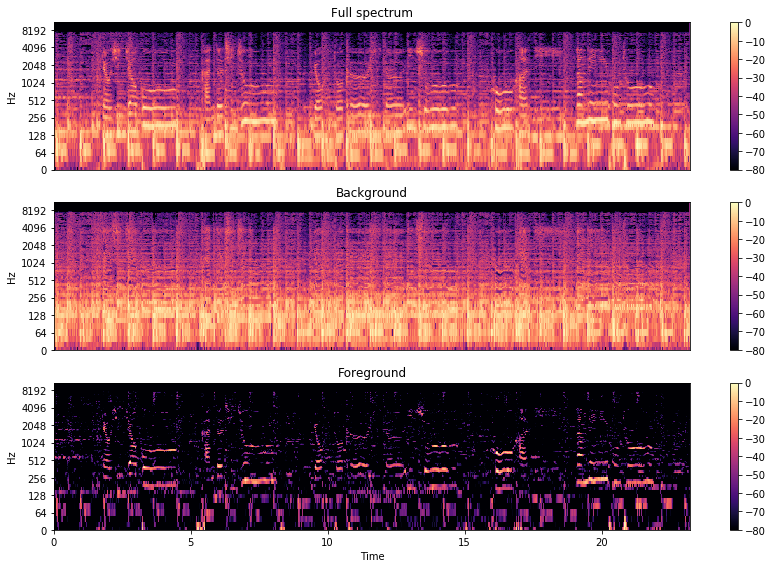

In [497]:
import librosa.display

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D_mix, ref=np.max),  y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(D_music, ref=np.max), y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(D_vocal, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()

plt.show()